In [1]:
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [2]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Getting into the directory folder of the monkey pictures
os.listdir('./training/training')
os.listdir('./validation/validation')

['n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9']

In [4]:
# Setting the path
training_dataset_path = './training/training'
test_dataset_path = './validation/validation'

In [5]:
# Declaring the mean and std variables
mean = [0.4363, 0.4328, 0.3291] # Got the mean from the function "get_mean_and_std"
std = [0.2129, 0.2075, 0.2037] # Got the std from the function "get_mean_and_std"

# Transforming the training and test dataset
training_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # Resize images to 224x224
    transforms.RandomHorizontalFlip(), # Randomly flip images horizontally, training becomes less bias
    transforms.RandomRotation(10), # Randomly rotates the images 10 degrees
    transforms.ToTensor(), # Convert images to PyTorch Tensors
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std)) # Normalize the dataset to improve the performance of the model
]) # Resizing the dataset to make them all the same size

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # Resize images to 224x224
    transforms.ToTensor(), # Convert images to PyTorch Tensors
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std)) # Normalize the dataset to improve the performance of the model
]) # Resizing the dataset to make them all the same size

In [6]:
train_dataset = torchvision.datasets.ImageFolder(root = training_dataset_path, transform = training_transforms)
test_dataset = torchvision.datasets.ImageFolder(root = test_dataset_path, transform = test_transforms)

In [7]:
# Just to see how the images look and how they are being transformed
def show_transformed_images(dataset):
    # Create a DataLoader to sample 6 images from the dataset randomly
    loader = torch.utils.data.DataLoader(dataset, batch_size = 6, shuffle=True)
    # Grab the first batch from the DataLoader
    batch = next(iter(loader))
    images, labels = batch
    
    # Create a grid of images (2 rows x 3 columns if nrows = 3)
    grid = torchvision.utils.make_grid(images, nrow = 3)

    # Create a figure and set its size (11 x 11 inches)
    plt.figure(figsize=(11,11))

    # Convert image from (C, H, W) to (H, W,C ) for display
    plt.imshow(np.transpose(grid, (1, 2, 0)))

    # Shows the labels associated with the images in the batch
    print('labels: ', labels)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0857832..3.2935688].


labels:  tensor([4, 5, 7, 2, 6, 0])


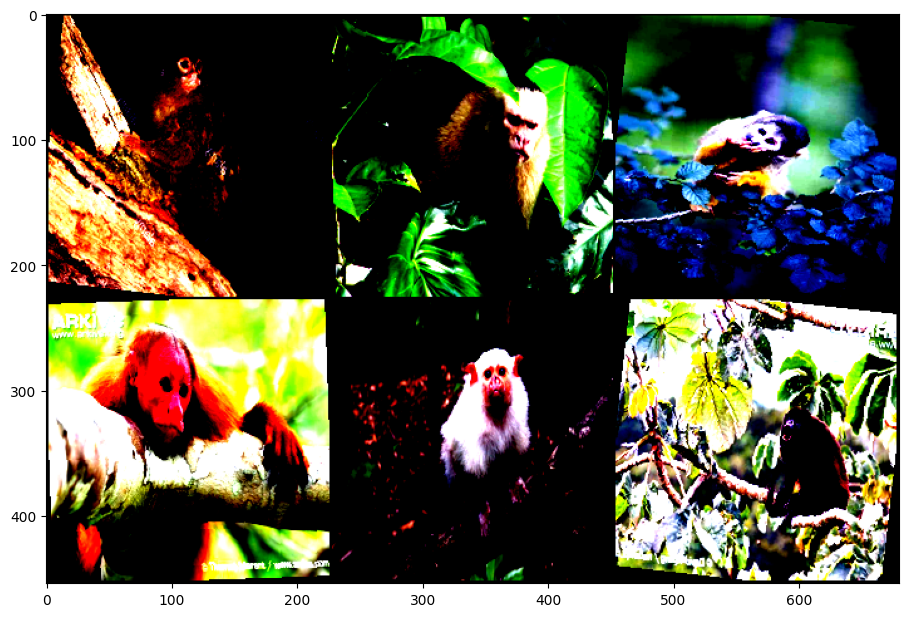

In [8]:
# Print the results
show_transformed_images(train_dataset)

In [9]:
# Mini-Batch Gradient Descent Algorithm
train_loader  = torch.utils.data.DataLoader(dataset = train_dataset, batch_size=32, shuffle=True) # Batch = 32, each batch will contain 32 images
test_loader  = torch.utils.data.DataLoader(dataset = train_dataset, batch_size=32, shuffle=False)


In [10]:
# Calculates the mean and std of each batch
def get_mean_and_std(loader):
    mean = 0.
    std = 0.
    total_image_count = 0
    # Iterate through all of the batches
    for images, _ in loader:
        # Get the number of images in the current batch
        image_count_in_a_batch = images.size(0)
        # Reshape each image
        images = images.view(image_count_in_a_batch, images.size(1), -1)     
        # Update the mean, std, total_image_count values
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_image_count += image_count_in_a_batch

    # Average Mean and Std values
    mean /= total_image_count
    std /= total_image_count

    return mean, std
        

In [11]:
get_mean_and_std(train_loader)

(tensor([-0.0738, -0.0800, -0.0605]), tensor([1.0620, 1.0637, 1.0317]))

In [12]:
# Check if a GPU (CUDA) is available and select the appropriate device
# This helps speed up neural network training if a GPU is present
def set_device():
    if torch.cuda.is_available():
        # Check if CUDA is available on the system
        dev = "cuda:0"
    else:
        # Fallback to CPU if no GPU is available
        dev = "cpu"
    return torch.device(dev)

In [13]:
# ResNet18 Model
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

# Load ResNet18 without pretrained weights, pretrained doesn't exist in newer versions
# Using weights instead of it
resnet18_model = models.resnet18(weights=None)

# Get the number of input features to the final fully connected layer
num_ftrs = resnet18_model.fc.in_features

# Define how many output classes the dataset has
number_of_classes = 10

# Replace the final fully connected layer with one for the number of classes
resnet18_model.fc = nn.Linear(num_ftrs, number_of_classes)

# Move model to GPU if available, else CPU
device = set_device()
resnet18_model = resnet18_model.to(device)

# Controls the error, the loss function
loss_fn = nn.CrossEntropyLoss()

# Define optimizer (SGD with learning rate, momentum, and weight decay)
# Parameters = tells the optimizer which parameters the model's weight and biases to update
# Learning Rate (lr) = Controls how big each step is during training
# Momentum = Helps speed up and smooth training
# Weight_decay = Helps prevent overfitting by keeping the model weights small
optimizer = optim.SGD(resnet18_model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.003)

In [14]:
def train_nn(model, train_loader, test_loader, criterion, optimizer, n_epochs):
    # Set the device
    device = set_device()
    # variable to track the best accuracy (best model so far out of the ones we test)
    best_acc = 0

    for epoch in range(n_epochs):
        # What the current Epoch number is
        print("Epoch number %d " % (epoch + 1))
        # Set model to training mode
        model.train()
        running_loss = 0.0 # Accumulates total loss for the epoch
        running_correct = 0.0 # Counts correct predictions
        total = 0 # Total number of images seen

        # Loop through all batches in the training data
        for data in train_loader:
            # Move images and labels to the same device as the model
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            # Add number of samples in this batch
            total += labels.size(0)

            # Clear any previously stored gradients
            optimizer.zero_grad()

            # Compute model output
            outputs = model(images)

            # Get predicted class per image
            _, predicted = torch.max(outputs.data, 1)

            loss = criterion(outputs, labels) # Calculate loss between predictions and true labels

            loss.backward() # Backward Pass: compute gradients

            optimizer.step() # Update model weights using gradients

            # Accumulate batch loss
            running_loss += loss.item()
            # Count correct predictions
            running_correct += (labels==predicted).sum().item()
        
        # Computer average loss and accuracy for the epoch
        epoch_loss = running_loss/len(train_loader)
        epoch_acc = 100.00 * running_correct / total

        # Print metrics for this epoch
        print("  - Training Dataset. Got %d out of %d images correctly (%.3f%%). Epoch loss: %.3f"
              % (running_correct, total, epoch_acc, epoch_loss))
        
        # stores the model's accuracy in this variable
        test_dataset_acc = evaluate_model_on_test_set(model, test_loader)
        
        # if the test accuracy is better than the best accuracy so far
        if (test_dataset_acc > best_acc):
            # store the new accuracy as the best
            best_acc = test_dataset_acc
            # save the settings for that model that provided the best accuracy
            save_checkpoint(model, epoch, optimizer, best_acc)

    print('Finished')
    return model



In [15]:
def evaluate_model_on_test_set(model, test_loader):
    # use the eval model and not the test model
    model.eval()
    # variable declaration
    predicted_correctly_on_epoch = 0
    total = 0
    device = set_device()
    
    # speed up the calculations
    with torch.no_grad():
        for data in test_loader:
            # get the data (images) total again
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            total += labels.size(0)
            # recalculate the outputs
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            # total the predictions that are correct
            predicted_correctly_on_epoch += (predicted == labels).sum().item()
            
    # calculate the accuracy
    epoch_acc = 100.00 * predicted_correctly_on_epoch / total
    print("  - Testing Datset. Got %d out of %d images correctly (%.3f%%)"
          % (predicted_correctly_on_epoch, total, epoch_acc))
    # return the accuracy from the function so that we can keep track of the accuracy across training methods
    return epoch_acc
    

In [16]:
def save_checkpoint(model, epoch, optimizer, best_acc):
    # dictionary to save the data passed as parameters
    state  = {
        'epoch': epoch + 1,
        'model': model.state_dict(),
        'best accuracy': best_acc,
        'optimizer': optimizer.state_dict(),
    }
    # creates the checkpoint as a file
    torch.save(state, 'model_best_checkpoint.pth.tar')

In [17]:
 # ResNet18 Model
 # re- initialize it for the evaluate model
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

resnet18_model = models.resnet18(weights=None)
num_ftrs = resnet18_model.fc.in_features
number_of_classes = 10

resnet18_model.fc = nn.Linear(num_ftrs, number_of_classes)
device = set_device()

resnet18_model = resnet18_model.to(device)
loss_fn = nn.CrossEntropyLoss()

optimizer = optim.SGD(resnet18_model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.003)

In [18]:
# train the model based on the variables we set up above
train_nn(resnet18_model, train_loader, test_loader, loss_fn, optimizer, 20)

Epoch number 1 
  - Training Dataset. Got 236 out of 1097 images correctly (21.513%). Epoch loss: 2.208
  - Testing Datset. Got 177 out of 1097 images correctly (16.135%)
Epoch number 2 
  - Training Dataset. Got 368 out of 1097 images correctly (33.546%). Epoch loss: 2.005
  - Testing Datset. Got 308 out of 1097 images correctly (28.077%)
Epoch number 3 
  - Training Dataset. Got 457 out of 1097 images correctly (41.659%). Epoch loss: 1.654
  - Testing Datset. Got 568 out of 1097 images correctly (51.778%)
Epoch number 4 
  - Training Dataset. Got 538 out of 1097 images correctly (49.043%). Epoch loss: 1.406
  - Testing Datset. Got 426 out of 1097 images correctly (38.833%)
Epoch number 5 
  - Training Dataset. Got 568 out of 1097 images correctly (51.778%). Epoch loss: 1.300
  - Testing Datset. Got 704 out of 1097 images correctly (64.175%)
Epoch number 6 
  - Training Dataset. Got 618 out of 1097 images correctly (56.335%). Epoch loss: 1.227
  - Testing Datset. Got 603 out of 1097 i

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [19]:
# trying the same test but with weights = true rather than none
# to see if accuracy improves
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

# can also use weights=ResNet18_Weights.DEFAULT but may need to include something
resnet18_model = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = resnet18_model.fc.in_features
number_of_classes = 10
resnet18_model.fc = nn.Linear(num_ftrs, number_of_classes)

device = set_device()

resnet18_model = resnet18_model.to(device)
loss_fn = nn.CrossEntropyLoss()

optimizer = optim.SGD(resnet18_model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.003)

In [20]:
# train the model based on the variables we set up above
train_nn(resnet18_model, train_loader, test_loader, loss_fn, optimizer, 20)

Epoch number 1 
  - Training Dataset. Got 850 out of 1097 images correctly (77.484%). Epoch loss: 0.646
  - Testing Datset. Got 1076 out of 1097 images correctly (98.086%)
Epoch number 2 
  - Training Dataset. Got 1078 out of 1097 images correctly (98.268%). Epoch loss: 0.063
  - Testing Datset. Got 1092 out of 1097 images correctly (99.544%)
Epoch number 3 
  - Training Dataset. Got 1079 out of 1097 images correctly (98.359%). Epoch loss: 0.060
  - Testing Datset. Got 1092 out of 1097 images correctly (99.544%)
Epoch number 4 
  - Training Dataset. Got 1079 out of 1097 images correctly (98.359%). Epoch loss: 0.044
  - Testing Datset. Got 1040 out of 1097 images correctly (94.804%)
Epoch number 5 
  - Training Dataset. Got 1092 out of 1097 images correctly (99.544%). Epoch loss: 0.023
  - Testing Datset. Got 1096 out of 1097 images correctly (99.909%)
Epoch number 6 
  - Training Dataset. Got 1095 out of 1097 images correctly (99.818%). Epoch loss: 0.011
  - Testing Datset. Got 1097 ou

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [21]:
# verifying the checkpoint works properly
# loading the file into a variable
checkpoint = torch.load('model_best_checkpoint.pth.tar')

In [22]:
# print the data from the checkpoint
print(checkpoint['epoch'])
print(checkpoint['best accuracy'])
print(checkpoint['model'])
print(checkpoint['optimizer'])

6
100.0
OrderedDict({'conv1.weight': tensor([[[[-1.8403e-02, -1.3156e-02, -8.1231e-03,  ...,  4.6753e-02,
            8.0229e-03, -1.6009e-02],
          [-6.6485e-04, -1.2911e-03, -1.1586e-01,  ..., -2.6487e-01,
           -1.2871e-01, -1.4035e-03],
          [-1.6432e-02,  4.5497e-02,  2.6778e-01,  ...,  4.8230e-01,
            2.3387e-01,  4.9662e-02],
          ...,
          [-3.0445e-02,  1.0101e-02,  6.1522e-02,  ..., -3.2167e-01,
           -4.0953e-01, -2.5877e-01],
          [ 2.0822e-02,  3.2795e-02,  5.2311e-02,  ...,  3.8476e-01,
            3.5935e-01,  1.4030e-01],
          [-2.0309e-02, -8.3575e-03, -2.4102e-02,  ..., -1.4461e-01,
           -8.7249e-02, -2.1192e-02]],

         [[-1.4329e-02, -2.7630e-02, -3.4019e-02,  ...,  2.8894e-02,
           -2.2997e-03, -2.3139e-02],
          [ 3.6783e-02,  2.7505e-02, -1.0453e-01,  ..., -2.9791e-01,
           -1.5311e-01, -9.2827e-04],
          [-4.8867e-03,  8.7746e-02,  3.7347e-01,  ...,  6.6418e-01,
            3.4368e-0

In [23]:
# saving the model into a file

# grabbing the model information again
resnet18_model = models.resnet18()
num_ftrs = resnet18_model.fc.in_features
number_of_classes = 10
resnet18_model.fc = nn.Linear(num_ftrs, number_of_classes)
# loading the checkpoint into the model
resnet18_model.load_state_dict(checkpoint['model'])
# save the updated model w/ the best accuracy state into a file
torch.save(resnet18_model, 'best_model.pth')